#### Feature Engineering pour la prédiction du prix Bitcoin

Ce module contient toutes les fonctions pour créer les features
à partir des données OHLCV brutes.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, isnan, row_number, lead, lag, avg
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .appName("Bitcoin") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/21 02:43:24 WARN Utils: Your hostname, zoro, resolves to a loopback address: 127.0.1.1; using 192.168.11.158 instead (on interface wlp1s0)
26/01/21 02:43:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/21 02:43:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def load_data(path: str):
    """Charge les fichiers parquet de la zone Silver"""
    df = spark.read.parquet(path)
    return df


df_silver = load_data("../../Data/Silver")
df_silver.show()

+-------------------+--------+--------+--------+--------+-------+--------------------+------------------+----------------+---------------------+----------------------+---------------+----------+--------------------+-----------------+-----------------+-------------------+
|          open_time|    open|    high|     low|   close| volume|          close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|close_t_plus_10|prev_close|              return|             MA_5|            MA_10|        taker_ratio|
+-------------------+--------+--------+--------+--------+-------+--------------------+------------------+----------------+---------------------+----------------------+---------------+----------+--------------------+-----------------+-----------------+-------------------+
|2026-01-18 21:40:00|95380.77|95380.77|95380.76|95380.77|0.44398|2026-01-18 21:40:...|     42347.1505478|             102|               0.0723|           6896.029671|       95412.86| 

In [4]:
df_silver.printSchema()

root
 |-- open_time: timestamp_ntz (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- close_time: timestamp_ntz (nullable = true)
 |-- quote_asset_volume: double (nullable = true)
 |-- number_of_trades: long (nullable = true)
 |-- taker_buy_base_volume: double (nullable = true)
 |-- taker_buy_quote_volume: double (nullable = true)
 |-- close_t_plus_10: double (nullable = true)
 |-- prev_close: double (nullable = true)
 |-- return: double (nullable = true)
 |-- MA_5: double (nullable = true)
 |-- MA_10: double (nullable = true)
 |-- taker_ratio: double (nullable = true)



In [5]:
# Vérifie si les features requises existent
features_requises = ["close_t_plus_10", "return", "MA_5", "MA_10", "taker_ratio"]

print("\nVerification des features:")
for feature in features_requises:
    existe = feature in df_silver.columns
    print(f"  {feature}: {'OK' if existe else 'MANQUANT'}")


Verification des features:
  close_t_plus_10: OK
  return: OK
  MA_5: OK
  MA_10: OK
  taker_ratio: OK


In [6]:
def prepare_ml_data(df, target_shift=10):
    """
    Prépare les données ML :
    - ajoute la target (close dans 10 minutes)
    - drop les NaN
    - retourne X, y
    """
    
    # Colonnes utilisées comme features
    feature_names = [
        "return", "MA_5", "MA_10", "taker_ratio",
        "volume", "high", "low", "open", "close"
    ]
    
    # Séparer X et y
    X = df_silver.select(feature_names)
    y = df_silver.select("target")

    return X, y, df_silver
    

In [7]:
from pyspark.sql.functions import col, isnan, sum
from pyspark.sql.types import DoubleType, FloatType

# Vérifier les NULLs
null_counts = df_silver.select([
    sum(col(c).isNull().cast("int")).alias(c) 
    for c in df_silver.columns
])
print("Valeurs NULL par colonne:")
null_counts.show()


Valeurs NULL par colonne:
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+---------------+----------+------+----+-----+-----------+
|open_time|open|high|low|close|volume|close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|close_t_plus_10|prev_close|return|MA_5|MA_10|taker_ratio|
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+---------------+----------+------+----+-----+-----------+
|        0|   0|   0|  0|    0|     0|         0|                 0|               0|                    0|                     0|              0|         0|     0|   0|    0|          0|
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+---------------+----------+------+----+-----+-----------+



In [8]:
# # Target: prix futur à T+10
target = "close_t_plus_10"

num_cols = [
    # Prix
    'open',
    'high',
    'low',
    'close',
    
    
    # Volumes
    'volume',
    'quote_asset_volume',
    'taker_buy_base_volume',
    'taker_buy_quote_volume',
    
    # Features calculées
    'MA_10',
    'prev_close',
    'return',
    'MA_5',
    'taker_ratio'
]

In [ ]:
import pandas as pd
from pyspark.sql.functions import corr
import matplotlib.pyplot as plt



corr_list = []
for c in num_cols:
    corr_value = df_silver.select(corr(c, target)).collect()[0][0]
    corr_list.append((c, corr_value))

df_corr = pd.DataFrame(corr_list, columns=["feature", "corr_with_target"])
df_corr = df_corr.sort_values(by="corr_with_target", ascending=False)
print(df_corr)


                   feature  corr_with_target
2                      low          0.980199
3                    close          0.980119
11                    MA_5          0.978149
1                     high          0.977795
9               prev_close          0.977712
0                     open          0.977711
8                    MA_10          0.973397
10                  return         -0.013018
5       quote_asset_volume         -0.047522
4                   volume         -0.050135
12             taker_ratio         -0.063119
7   taker_buy_quote_volume         -0.086690
6    taker_buy_base_volume         -0.089085


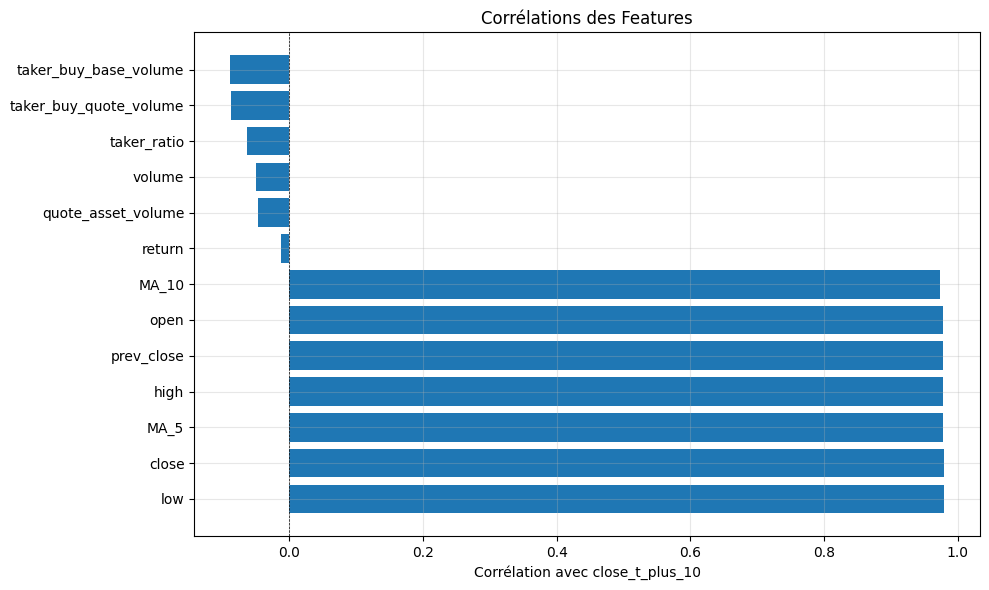

In [10]:
# CELLULE 4: Visualiser les corrélations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(df_corr['feature'], df_corr['corr_with_target'])
plt.xlabel('Corrélation avec close_t_plus_10')
plt.title('Corrélations des Features')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# CELLULE 1: Convertir close_time en numérique
from pyspark.sql.functions import unix_timestamp, corr

df_test = df_silver.withColumn(
    "close_time_numeric", 
    unix_timestamp("close_time")
)

# Corrélation close_time
corr_time = df_test.select(corr("close_time_numeric", "close_t_plus_10")).collect()[0][0]
print(f"Corrélation close_time: {corr_time:.6f}")

# CELLULE 2: Corrélation number_of_trades
corr_trades = df_silver.select(corr("number_of_trades", "close_t_plus_10")).collect()[0][0]
print(f"Corrélation number_of_trades: {corr_trades:.6f}")

Corrélation close_time: -0.387971
Corrélation number_of_trades: -0.089926


#### Définir features et target

In [12]:
# Colonnes utilisées comme features 
# basées sur la corrélation

# feature_names = [
#         "MA_5", "high", "low", "open", "close", "MA_10", "prev_close"
#     ]


feature_names = [
    'return',           # Variation t-1 → t
    'MA_5',             # Moyenne mobile 5 min (AVANT t)
    'MA_10',            # Moyenne mobile 10 min (AVANT t)
    'volume',           # Volume total
    'taker_ratio',      # Ratio acheteurs agressifs
    'prev_close'        # Prix précédent (t-1)
]


In [13]:
# Vérifier la corrélation
from pyspark.sql.functions import corr

# Si corrélation > 0.95, il y a leakage !
df_silver.select(
    corr("close", target).alias("corr_close_target"),
    corr("MA_5", target).alias("corr_MA5_target"),
    corr("MA_10", target).alias("corr_MA10_target")
).show()

+------------------+------------------+------------------+
| corr_close_target|   corr_MA5_target|  corr_MA10_target|
+------------------+------------------+------------------+
|0.9801189503037775|0.9781486436903549|0.9733966667696874|
+------------------+------------------+------------------+



#### Préparer les données

“L'utilisation de Window sans partition est nécessaire pour le calcul des features temporelles. 
Pour le split train/test, nous utilisons un découpage chronologique basé sur le temps afin d'éviter le shuffle et le data leakage.”

In [16]:
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.ml.feature import VectorAssembler

def prepare_ml_data(df, feature_names, target_col):
    """
    Prépare les données pour le ML avec split temporel exact 80/20
    """

    # Vectorisation des features
    assembler = VectorAssembler(
        inputCols=feature_names,
        outputCol="features",
        handleInvalid="skip"
    )
    df = assembler.transform(df)

    # Index temporel
    window = Window.orderBy("open_time")
    df = df.withColumn("time_index", row_number().over(window))

    # Split exact
    total_rows = df.count()
    split_point = int(total_rows * 0.8)

    df_train = df.filter(col("time_index") <= split_point)
    df_test = df.filter(col("time_index") > split_point)

    # Vérification fuite temporelle
    train_max_time = df_train.agg({"open_time": "max"}).collect()[0][0]
    test_min_time = df_test.agg({"open_time": "min"}).collect()[0][0]

    if train_max_time >= test_min_time:
        print("ATTENTION: Fuite temporelle détectée !")
    else:
        print("Pas de fuite temporelle")

    return df_train, df_test


In [17]:
# df_train, df_test= prepare_ml_data(df_silver, feature_names, target)

df_train, df_test = prepare_ml_data(df_silver, feature_names, target)


26/01/21 02:44:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Pas de fuite temporelle


In [18]:
lr = LinearRegression(
    featuresCol="features",
    labelCol=target,
    maxIter=100
)

model_lr = lr.fit(df_train)
print("Linear Regression entrainé")

26/01/21 02:44:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
26/01/21 02:44:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance

Linear Regression entrainé


In [19]:
predictions_lr = model_lr.transform(df_test)

evaluator_rmse = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="rmse"
)
evaluator_mae = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="mae"
)
evaluator_r2 = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="r2"
)

rmse_lr = evaluator_rmse.evaluate(predictions_lr)
mae_lr = evaluator_mae.evaluate(predictions_lr)
r2_lr = evaluator_r2.evaluate(predictions_lr)

print(f"\nLinear Regression:")
print(f"  RMSE: ${rmse_lr:.2f}")
print(f"  MAE: ${mae_lr:.2f}")
print(f"  R2: {r2_lr:.4f}")

26/01/21 02:44:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 0


Linear Regression:
  RMSE: $81.77
  MAE: $66.14
  R2: 0.2716


26/01/21 02:44:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:44:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [20]:
# 7. Random Forest optimisé
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=target,
    numTrees=150,
    maxDepth=15,
    minInstancesPerNode=1,
    seed=42
)

model_rf = rf.fit(df_train)
predictions_rf = model_rf.transform(df_test)

# 8. Métriques
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

rmse_rf = evaluator_rmse.evaluate(predictions_rf)
mae_rf = evaluator_mae.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)

print(f"\nRandom Forest Optimisé:")
print(f"  RMSE: ${rmse_rf:.2f}")
print(f"  MAE:  ${mae_rf:.2f}")
print(f"  R2:   {r2_rf:.4f}")

26/01/21 02:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1301.9 KiB
26/01/21 02:45:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
26/01/21 02:45:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
26/01/21 02:45:13 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
26/01/21 02:45:14 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
26/01/21 02:45:16 WARN DAGScheduler: Broadcasting large task binary with


Random Forest Optimisé:
  RMSE: $83.86
  MAE:  $67.56
  R2:   0.2339


26/01/21 02:45:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [21]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# Grid search
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=target,
    seed=42
)

# Paramètres à tester
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [8, 10, 15]) \
    .addGrid(rf.minInstancesPerNode, [1, 2]) \
    .build()

In [22]:
# Cross-validation (3 folds temporels)
evaluator = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="rmse"
)

# ATTENTION: CrossValidator fait du shuffle, donc on va tester manuellement
# Test manuel des meilleurs paramètres
best_params = [
    {"numTrees": 150, "maxDepth": 15, "minInstancesPerNode": 1},
    {"numTrees": 100, "maxDepth": 12, "minInstancesPerNode": 1},
    {"numTrees": 200, "maxDepth": 10, "minInstancesPerNode": 2}
]

results = []

for params in best_params:
    rf_test = RandomForestRegressor(
        featuresCol="features",
        labelCol=target,
        numTrees=params["numTrees"],
        maxDepth=params["maxDepth"],
        minInstancesPerNode=params["minInstancesPerNode"],
        seed=42
    )
    
    model_test = rf_test.fit(df_train)
    predictions_test = model_test.transform(df_test)
    
    rmse_test = evaluator.evaluate(predictions_test)
    
    results.append({
        "params": params,
        "rmse": rmse_test
    })
    
    print(f"Params: {params} -> RMSE: ${rmse_test:.2f}")

# Trouver le meilleur
best_result = min(results, key=lambda x: x["rmse"])
print(f"\nMeilleurs paramètres: {best_result['params']}")
print(f"RMSE: ${best_result['rmse']:.2f}")

# Réentraîner avec les meilleurs paramètres
rf_final = RandomForestRegressor(
    featuresCol="features",
    labelCol=target,
    **best_result['params'],
    seed=42
)

model_rf = rf_final.fit(df_train)
predictions_rf = model_rf.transform(df_test)

# Métriques finales
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

rmse_rf = evaluator_rmse.evaluate(predictions_rf)
mae_rf = evaluator_mae.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)

print(f"\nRandom Forest Optimisé:")
print(f"  RMSE: ${rmse_rf:.2f}")
print(f"  MAE:  ${mae_rf:.2f}")
print(f"  R2:   {r2_rf:.4f}")

26/01/21 02:45:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:34 WARN DAGScheduler: Broadcasting large task binary with size 1301.8 KiB
26/01/21 02:45:34 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
26/01/21 02:45:35 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
26/01/21 02:45:36 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
26/01/21 02:45:37 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
26/01/21 02:45:39 WARN DAGScheduler: Broadcasting large task binary with

Params: {'numTrees': 150, 'maxDepth': 15, 'minInstancesPerNode': 1} -> RMSE: $83.86


26/01/21 02:45:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1449.7 KiB
26/01/21 02:45:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
26/01/21 02:45:48 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
26/01/21 02:45:49 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
26/01/21 02:45:49 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
26/01/21 02:45:50 WARN DAGScheduler: Broadcasting large task binary with

Params: {'numTrees': 100, 'maxDepth': 12, 'minInstancesPerNode': 1} -> RMSE: $80.97


26/01/21 02:45:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:45:53 WARN DAGScheduler: Broadcasting large task binary with size 1656.2 KiB
26/01/21 02:45:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
26/01/21 02:45:54 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
26/01/21 02:45:55 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
26/01/21 02:45:56 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
26/01/21 02:45:56 WARN DAGScheduler: Broadcasting large task binary with

Params: {'numTrees': 200, 'maxDepth': 10, 'minInstancesPerNode': 2} -> RMSE: $80.67

Meilleurs paramètres: {'numTrees': 200, 'maxDepth': 10, 'minInstancesPerNode': 2}
RMSE: $80.67


26/01/21 02:45:58 WARN DAGScheduler: Broadcasting large task binary with size 1656.2 KiB
26/01/21 02:45:59 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
26/01/21 02:45:59 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
26/01/21 02:46:00 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
26/01/21 02:46:01 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
26/01/21 02:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1097.2 KiB
26/01/21 02:46:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:46:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:46:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performa


Random Forest Optimisé:
  RMSE: $80.67
  MAE:  $65.04
  R2:   0.2910


In [23]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluateurs
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

# ========== GBT - Grid Search ==========
print("🔥 Test GBTRegressor avec différentes configurations\n")

gbt_configs = [
    # Configuration conservatrice (éviter overfitting)
    {"maxIter": 30, "maxDepth": 4, "stepSize": 0.1, "subsamplingRate": 0.8},
    {"maxIter": 50, "maxDepth": 5, "stepSize": 0.1, "subsamplingRate": 0.8},
    
    # Configuration moyenne
    {"maxIter": 75, "maxDepth": 6, "stepSize": 0.08, "subsamplingRate": 0.8},
    {"maxIter": 100, "maxDepth": 5, "stepSize": 0.05, "subsamplingRate": 0.8},
    
    # Configuration agressive (plus de puissance)
    {"maxIter": 100, "maxDepth": 7, "stepSize": 0.1, "subsamplingRate": 0.7},
    {"maxIter": 150, "maxDepth": 6, "stepSize": 0.08, "subsamplingRate": 0.7},
    
    # Configuration très profonde
    {"maxIter": 200, "maxDepth": 8, "stepSize": 0.05, "subsamplingRate": 0.8},
]

results_gbt = []

for i, config in enumerate(gbt_configs, 1):
    print(f"[{i}/{len(gbt_configs)}] Test: {config}")
    
    gbt = GBTRegressor(
        featuresCol="features",
        labelCol=target,
        maxIter=config["maxIter"],
        maxDepth=config["maxDepth"],
        stepSize=config["stepSize"],
        subsamplingRate=config["subsamplingRate"],
        seed=42
    )
    
    # Entraînement
    model = gbt.fit(df_train)
    predictions = model.transform(df_test)
    
    # Métriques
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    
    results_gbt.append({
        "config": config,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "model": model
    })
    
    print(f"   RMSE: ${rmse:.2f} | MAE: ${mae:.2f} | R²: {r2:.4f}\n")

# Trouver le meilleur
best_gbt = min(results_gbt, key=lambda x: x["rmse"])

print("=" * 60)
print("🏆 MEILLEUR GBT:")
print(f"   Config: {best_gbt['config']}")
print(f"   RMSE: ${best_gbt['rmse']:.2f}")
print(f"   MAE: ${best_gbt['mae']:.2f}")
print(f"   R²: {best_gbt['r2']:.4f}")
print("=" * 60)

# Feature importance pour GBT
print("\n📊 Importance des features (GBT):")
for feature, importance in zip(feature_names, best_gbt['model'].featureImportances):
    print(f"  {feature}: {importance:.4f}")

🔥 Test GBTRegressor avec différentes configurations

[1/7] Test: {'maxIter': 30, 'maxDepth': 4, 'stepSize': 0.1, 'subsamplingRate': 0.8}


26/01/21 02:48:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:48:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:48:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:48:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:48:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:48:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 0

   RMSE: $96.36 | MAE: $68.29 | R²: -0.0116

[2/7] Test: {'maxIter': 50, 'maxDepth': 5, 'stepSize': 0.1, 'subsamplingRate': 0.8}


26/01/21 02:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 0

   RMSE: $101.87 | MAE: $73.61 | R²: -0.1306

[3/7] Test: {'maxIter': 75, 'maxDepth': 6, 'stepSize': 0.08, 'subsamplingRate': 0.8}


26/01/21 02:49:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:49:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:49:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:49:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:49:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:49:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 0

   RMSE: $110.72 | MAE: $81.53 | R²: -0.3355

[4/7] Test: {'maxIter': 100, 'maxDepth': 5, 'stepSize': 0.05, 'subsamplingRate': 0.8}


26/01/21 02:49:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:49:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:49:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:50:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:50:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:50:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 0

   RMSE: $92.25 | MAE: $71.02 | R²: 0.0730

[5/7] Test: {'maxIter': 100, 'maxDepth': 7, 'stepSize': 0.1, 'subsamplingRate': 0.7}


26/01/21 02:50:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:50:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:50:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:50:49 WARN DAGScheduler: Broadcasting large task binary with size 1000.5 KiB
26/01/21 02:50:49 WARN DAGScheduler: Broadcasting large task binary with size 1002.3 KiB
26/01/21 02:50:49 WARN DAGScheduler: Broadcasting large task binary with size 1005.4 KiB
26/01/21 02:50:49 WARN DAGScheduler: Broadcasting large task binary with size 1010.0 KiB
26/01/21 02:50:49 WARN DAGScheduler: Broadcasting large task binary with size 1011.6 KiB
26/01/21 02:50:49 WARN DAGScheduler: Broadcasting large task

   RMSE: $103.17 | MAE: $77.99 | R²: -0.1596

[6/7] Test: {'maxIter': 150, 'maxDepth': 6, 'stepSize': 0.08, 'subsamplingRate': 0.7}


26/01/21 02:51:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:51:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:51:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1002.3 KiB
26/01/21 02:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB
26/01/21 02:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1009.4 KiB
26/01/21 02:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB
26/01/21 02:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1010.8 KiB
26/01/21 02:51:59 WARN DAGScheduler: Broadcasting large task

   RMSE: $98.50 | MAE: $74.67 | R²: -0.0570

[7/7] Test: {'maxIter': 200, 'maxDepth': 8, 'stepSize': 0.05, 'subsamplingRate': 0.8}


26/01/21 02:52:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:52:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:52:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/21 02:53:02 WARN DAGScheduler: Broadcasting large task binary with size 1002.9 KiB
26/01/21 02:53:02 WARN DAGScheduler: Broadcasting large task binary with size 1010.7 KiB
26/01/21 02:53:02 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB
26/01/21 02:53:02 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
26/01/21 02:53:02 WARN DAGScheduler: Broadcasting large task binary with size 1011.3 KiB
26/01/21 02:53:02 WARN DAGScheduler: Broadcasting large task

Py4JJavaError: An error occurred while calling o26223.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task serialization failed: java.lang.StackOverflowError
java.lang.StackOverflowError
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1381)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1177)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1381)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1177)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)

	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:3122)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:3122)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:3114)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:3114)
	at org.apache.spark.scheduler.DAGScheduler.submitMissingTasks(DAGScheduler.scala:1696)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1478)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$submitStage$5(DAGScheduler.scala:1481)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$submitStage$5$adapted(DAGScheduler.scala:1480)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1480)
	at org.apache.spark.scheduler.DAGScheduler.handleJobSubmitted(DAGScheduler.scala:1408)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3340)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3328)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3317)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1017)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2496)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2517)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2536)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2561)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:740)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:739)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:693)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:219)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:454)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:58)
	at org.apache.spark.ml.regression.GBTRegressor.$anonfun$train$1(GBTRegressor.scala:190)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:226)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:226)
	at org.apache.spark.ml.regression.GBTRegressor.train(GBTRegressor.scala:167)
	at org.apache.spark.ml.regression.GBTRegressor.train(GBTRegressor.scala:57)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:79)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.lang.StackOverflowError
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1381)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1177)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1381)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1177)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1(DefaultSerializationProxy.scala:38)
	at scala.collection.generic.DefaultSerializationProxy.$anonfun$writeObject$1$adapted(DefaultSerializationProxy.scala:37)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at scala.collection.generic.DefaultSerializationProxy.writeObject(DefaultSerializationProxy.scala:37)
	at jdk.internal.reflect.GeneratedMethodAccessor27.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1070)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1516)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1572)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1529)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1438)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1181)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:350)
